In [1]:
import gurobipy as gp
import numpy as np
import pandas as pd
from scipy import stats


from gurobi_implementation import GurobiSolution
from data_market import Seller, MarketOperator, Market, Buyer
from p2p_gurobi import Agents, FirstStageMarket

In [2]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

In [3]:
connection_matrix = [[0, 1, 1, 1, 1],
                    [1, 0, 1, 1, 1],
                    [1, 1, 0, 1, 1],
                    [1, 1, 1, 0, 1],
                    [1, 1, 1, 1, 0]]

kappa = [[0, 10, 10, 10, 10],
        [10, 0, 10, 10, 10],
        [10, 10, 0, 10, 10],
        [10, 10, 10, 0, 10],
        [10, 10, 10, 10, 0]]    

#kappa = [[1 for i in range(5)] for k in range(5)]               

In [4]:
#model_1
actual_generations = [3, 4, 5, 4, 3]
demand = [6, 7, 8, 9, 10]

price_da_buy = 3
price_da_sell = 2
price_rt_buy = 4
price_rt_sell = 1

base_forecasts = [stats.norm(loc = generation, scale = 2.0) for generation in actual_generations]

agents_forecasts = []
for base_forecast in base_forecasts:
    probas, values = np.histogram(base_forecast.rvs(100000), bins = 100, density = True)
    probas = probas / probas.sum()
    agents_forecasts.append((probas, values))

agents = []
for id, actual_generation in enumerate(actual_generations):
    agent = Agents(id = id,
                probabilities = agents_forecasts[id][0],
                generation_values = agents_forecasts[id][1],
                demand = demand[id],
                connections = connection_matrix[id],
                kappa = kappa[id])

    agents.append(agent)

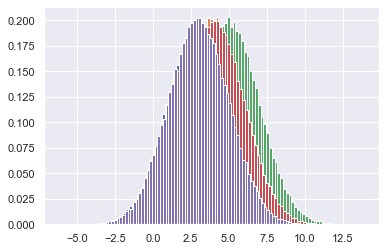

In [5]:
for i in range(5):
    plt.hist(base_forecasts[i].rvs(100000), bins = 100, density = True);

In [6]:
model_1 = gp.Model()

In [7]:
market_1 = FirstStageMarket(agents= agents,
                            model = model_1,
                            price_da_buy = price_da_buy,
                            price_da_sell = price_da_sell,
                            price_rt_buy = price_rt_buy,
                            price_rt_sell = price_rt_sell)

In [8]:
market_1.build_model()

In [9]:
model_1.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 499 rows, 983 columns and 2435 nonzeros
Model fingerprint: 0x71b24a43
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 3e+00]
  Bounds range     [1e+01, 1e+01]
  RHS range        [2e-02, 2e+01]
Presolve removed 20 rows and 10 columns
Presolve time: 0.01s
Presolved: 479 rows, 973 columns, 2395 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     726    8.7178898e+01   0.000000e+00   0.000000e+00      0s

Solved in 726 iterations and 0.01 seconds (0.01 work units)
Optimal objective  8.717889785e+01


In [10]:
def second_stage_resolution(model, agents, actual_generations):
    second_stage_decisions = []
    actual_costs = []
    for agent in agents:
        second_stage_decision = (agent.demand 
                                - actual_generations[agent.id] 
                                - model.getVarByName(f'Agent {agent.id} day-ahead purchase').X
                                + model.getVarByName(f'Agent {agent.id} day-ahead sale').X
                                - model.getVarByName(f'Agent {agent.id} net trading').X)

        second_stage_cost = price_rt_buy * second_stage_decision if second_stage_decision > 0 else price_rt_sell * second_stage_decision

        second_stage_decisions.append(second_stage_decision)

        actual_cost = (price_da_buy * model.getVarByName(f'Agent {agent.id} day-ahead purchase').X 
                    - price_da_sell * model.getVarByName(f'Agent {agent.id} day-ahead sale').X
                    + second_stage_cost)


        actual_costs.append(actual_cost)

    return second_stage_decisions, actual_costs
        

In [11]:
second_stage_resolution(model_1, agents, actual_generations)

([0.7456521049106826,
  -0.27484121398219763,
  -1.2886643151806414,
  -0.31699078264521674,
  0.8054299589226765],
 [2.9826084196427303,
  -0.27484121398219763,
  -1.2886643151806414,
  63.67125196127887,
  3.221719835690706])

In [12]:
sum(second_stage_resolution(model_1, agents, actual_generations)[1])

68.31207468744947

In [13]:
#model_2
actual_generations = [3, 4, 5, 4, 3]
demand = [6, 7, 8, 9, 10]

price_da_buy = 3
price_da_sell = 2
price_rt_buy = 4
price_rt_sell = 1

base_forecasts = [stats.norm(loc = generation, scale = 1.0) for generation in actual_generations]

agents_forecasts = []
for base_forecast in base_forecasts:
    probas, values = np.histogram(base_forecast.rvs(100000), bins = 100, density = True)
    probas = probas / probas.sum()
    agents_forecasts.append((probas, values))

agents = []
for id, actual_generation in enumerate(actual_generations):
    agent = Agents(id = id,
                probabilities = agents_forecasts[id][0],
                generation_values = agents_forecasts[id][1],
                demand = demand[id],
                connections = connection_matrix[id],
                kappa = kappa[id])

    agents.append(agent)

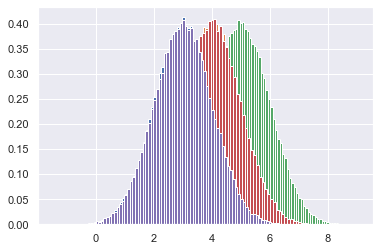

In [14]:
for i in range(5):
    plt.hist(base_forecasts[i].rvs(100000), bins = 100, density = True);

In [15]:
model_2 = gp.Model()

market_2 = FirstStageMarket(agents= agents,
                            model = model_2,
                            price_da_buy = price_da_buy,
                            price_da_sell = price_da_sell,
                            price_rt_buy = price_rt_buy,
                            price_rt_sell = price_rt_sell)

In [16]:
market_2.build_model()

In [17]:
model_2.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 498 rows, 981 columns and 2430 nonzeros
Model fingerprint: 0x8fa4e06c
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 3e+00]
  Bounds range     [1e+01, 1e+01]
  RHS range        [5e-03, 1e+01]
Presolve removed 20 rows and 10 columns
Presolve time: 0.01s
Presolved: 478 rows, 971 columns, 2390 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     700    8.1144484e+01   0.000000e+00   0.000000e+00      0s

Solved in 700 iterations and 0.01 seconds (0.01 work units)
Optimal objective  8.114448406e+01


In [18]:
second_stage_resolution(model_2, agents, actual_generations)

([0.43072624428751816,
  -0.6557063231542655,
  -1.6503784684784577,
  -0.5890611495518039,
  0.3786548155758478],
 [1.7229049771500726,
  -0.6557063231542655,
  67.60691617548503,
  -0.5890611495518039,
  1.5146192623033912])

In [19]:
sum(second_stage_resolution(model_2, agents, actual_generations)[1])

69.59967294223242

In [20]:
#model_3
actual_generations = [3, 4, 5, 4, 3]
demand = [6, 7, 8, 9, 10]

price_da_buy = 3
price_da_sell = 2
price_rt_buy = 4
price_rt_sell = 1

base_forecasts = [stats.norm(loc = generation, scale = 0.2) for generation in actual_generations]

agents_forecasts = []
for base_forecast in base_forecasts:
    probas, values = np.histogram(base_forecast.rvs(100000), bins = 100, density = True)
    probas = probas / probas.sum()
    agents_forecasts.append((probas, values))

agents = []
for id, actual_generation in enumerate(actual_generations):
    agent = Agents(id = id,
                probabilities = agents_forecasts[id][0],
                generation_values = agents_forecasts[id][1],
                demand = demand[id],
                connections = connection_matrix[id],
                kappa = kappa[id])

    agents.append(agent)

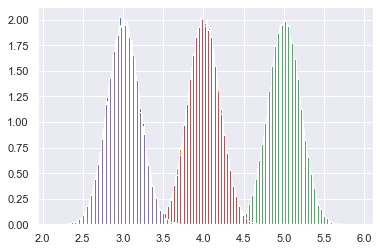

In [21]:
for i in range(5):
    plt.hist(base_forecasts[i].rvs(100000), bins = 100, density = True);

In [22]:
model_3 = gp.Model()

market_3 = FirstStageMarket(agents= agents,
                            model = model_3,
                            price_da_buy = price_da_buy,
                            price_da_sell = price_da_sell,
                            price_rt_buy = price_rt_buy,
                            price_rt_sell = price_rt_sell)

In [23]:
market_3.build_model()
model_3.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 511 rows, 1007 columns and 2495 nonzeros
Model fingerprint: 0x11df00f3
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 3e+00]
  Bounds range     [1e+01, 1e+01]
  RHS range        [2e+00, 8e+00]
Presolve removed 20 rows and 10 columns
Presolve time: 0.00s
Presolved: 491 rows, 997 columns, 2455 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     724    7.6216201e+01   0.000000e+00   0.000000e+00      0s

Solved in 724 iterations and 0.01 seconds (0.01 work units)
Optimal objective  7.621620126e+01


In [24]:
second_stage_resolution(model_3, agents, actual_generations)

([0.08541632696667456,
  -0.9140666539340994,
  -1.9131064893023595,
  -0.9237463996397359,
  0.06931689278571262],
 [0.34166530786669824,
  -0.9140666539340994,
  -1.9131064893023595,
  72.86481256973168,
  0.2772675711428505])

In [25]:
sum(second_stage_resolution(model_3, agents, actual_generations)[1])

70.65657230550477

In [53]:
#model_4
actual_generations = [3, 4, 5, 4, 3]
demand = [6, 7, 8, 9, 10]

price_da_buy = 3
price_da_sell = 2
price_rt_buy = 4
price_rt_sell = 1

base_forecasts = [stats.norm(loc = generation, scale = 0.0) for generation in actual_generations]

agents_forecasts = []
for base_forecast in base_forecasts:
    probas, values = np.histogram(base_forecast.rvs(100000), bins = 100, density = True)
    probas = probas / probas.sum()
    agents_forecasts.append((probas, values))

agents = []
for id, actual_generation in enumerate(actual_generations):
    agent = Agents(id = id,
                probabilities = agents_forecasts[id][0],
                generation_values = agents_forecasts[id][1],
                demand = demand[id],
                connections = connection_matrix[id],
                kappa = kappa[id])

    agents.append(agent)

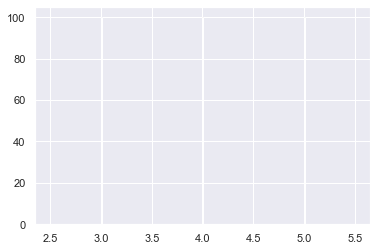

In [54]:
for i in range(5):
    plt.hist(base_forecasts[i].rvs(100000), bins = 100, density = True);

In [27]:
model_4 = gp.Model()

market_4 = FirstStageMarket(agents= agents,
                            model = model_4,
                            price_da_buy = price_da_buy,
                            price_da_sell = price_da_sell,
                            price_rt_buy = price_rt_buy,
                            price_rt_sell = price_rt_sell)

market_4.build_model()
model_4.optimize()                            

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 30 rows, 45 columns and 90 nonzeros
Model fingerprint: 0x4464a208
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 4e+00]
  Bounds range     [1e+01, 1e+01]
  RHS range        [3e+00, 7e+00]
Presolve removed 25 rows and 20 columns
Presolve time: 0.00s
Presolved: 5 rows, 25 columns, 35 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5000000e+02   4.050000e+01   0.000000e+00      0s
       4    7.5000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.500000000e+01


In [28]:
second_stage_resolution(model_4, agents, actual_generations)

([0.0, -1.0, -2.0, -1.0, 0.0], [75.0, -1.0, -2.0, -1.0, 0.0])

In [29]:
sum(second_stage_resolution(model_4, agents, actual_generations)[1])

71.0

In [30]:
print('Model_1 net trades:', [model_1.getVarByName(f'Agent {id} net trading').X for id, _ in enumerate(agents)])
print('Model_2 net trades:', [model_2.getVarByName(f'Agent {id} net trading').X for id, _ in enumerate(agents)])
print('Model_3 net trades:', [model_3.getVarByName(f'Agent {id} net trading').X for id, _ in enumerate(agents)])
print('Model_4 net trades:', [model_4.getVarByName(f'Agent {id} net trading').X for id, _ in enumerate(agents)])

Model_1 net trades: [2.2543478950893174, 3.2748412139821976, 4.288664315180641, -16.01242346532948, 6.1945700410773235]
Model_2 net trades: [2.569273755712482, 3.6557063231542655, -18.435386412842703, 5.589061149551804, 6.621345184424152]
Model_3 net trades: [2.9145836730333254, 3.9140666539340994, 4.9131064893023595, -18.67243992348407, 6.930683107214287]
Model_4 net trades: [-22.0, 4.0, 5.0, 6.0, 7.0]


In [31]:
duals = model_1.getAttr('Pi')

In [32]:
const_names = model_1.getConstrs()

In [33]:
for x in zip(const_names, duals):
    if str(x[0]) in [f'<gurobi.Constr Bilateral trading for pair ({a}, {b})>' for a in range(5) for b in range(5)]:
        print(x)

(<gurobi.Constr Bilateral trading for pair (0, 1)>, 0.0)
(<gurobi.Constr Bilateral trading for pair (0, 2)>, 0.0)
(<gurobi.Constr Bilateral trading for pair (0, 3)>, 0.0)
(<gurobi.Constr Bilateral trading for pair (0, 4)>, 0.0)
(<gurobi.Constr Bilateral trading for pair (1, 0)>, -3.0000000000000018)
(<gurobi.Constr Bilateral trading for pair (1, 2)>, -3.0000000000000018)
(<gurobi.Constr Bilateral trading for pair (1, 3)>, -3.0000000000000018)
(<gurobi.Constr Bilateral trading for pair (1, 4)>, 0.0)
(<gurobi.Constr Bilateral trading for pair (2, 0)>, -3.0000000000000018)
(<gurobi.Constr Bilateral trading for pair (2, 1)>, 0.0)
(<gurobi.Constr Bilateral trading for pair (2, 3)>, 0.0)
(<gurobi.Constr Bilateral trading for pair (2, 4)>, 0.0)
(<gurobi.Constr Bilateral trading for pair (3, 0)>, -3.0000000000000018)
(<gurobi.Constr Bilateral trading for pair (3, 1)>, 0.0)
(<gurobi.Constr Bilateral trading for pair (3, 2)>, -3.0000000000000018)
(<gurobi.Constr Bilateral trading for pair (3, 4)

In [34]:
def trading_costs(agents, model):
    res = []
    duals = model.getAttr('Pi')
    const_names = model.getConstrs()

    for agent in agents:
        agent_trading_cost = 0
        for x in zip(const_names, duals):
            for agent_2 in agents:
                if str(x[0]) == f'<gurobi.Constr Bilateral trading for pair ({agent.id}, {agent_2.id})>':
                    #print(f'q_{agent.id}_{agent_2.id}:', x[1], model.getVarByName(f'q_{agent.id}_{agent_2.id}').X)
                    agent_trading_cost += abs(x[1]) * abs(model.getVarByName(f'q_{agent.id}_{agent_2.id}').X)

        res.append(agent_trading_cost)

    return res

In [35]:
sum(np.array(trading_costs(agents, model_1)) + np.array(second_stage_resolution(model_1, agents, actual_generations)[1]))

299.41082504011666

In [36]:
sum(np.array(trading_costs(agents, model_2)) + np.array(second_stage_resolution(model_2, agents, actual_generations)[1]))

306.50282083761533

In [37]:
sum(np.array(trading_costs(agents, model_3)) + np.array(second_stage_resolution(model_3, agents, actual_generations)[1]))

304.66100385669756

In [38]:
sum(np.array(trading_costs(agents, model_4)) + np.array(second_stage_resolution(model_4, agents, actual_generations)[1]))

284.0

In [39]:
model_4.getVars()

[<gurobi.Var Agent 0 day-ahead purchase (value 25.0)>,
 <gurobi.Var Agent 0 day-ahead sale (value 0.0)>,
 <gurobi.Var Agent 0 proba 50 real-time purchase (value 0.0)>,
 <gurobi.Var Agent 0 proba 50 real-time sale (value 0.0)>,
 <gurobi.Var q_0_1 (value -10.0)>,
 <gurobi.Var q_0_2 (value -2.0)>,
 <gurobi.Var q_0_3 (value 0.0)>,
 <gurobi.Var q_0_4 (value -10.0)>,
 <gurobi.Var Agent 0 net trading (value -22.0)>,
 <gurobi.Var Agent 1 day-ahead purchase (value 0.0)>,
 <gurobi.Var Agent 1 day-ahead sale (value 0.0)>,
 <gurobi.Var Agent 1 proba 50 real-time purchase (value 0.0)>,
 <gurobi.Var Agent 1 proba 50 real-time sale (value 0.0)>,
 <gurobi.Var q_1_0 (value 10.0)>,
 <gurobi.Var q_1_2 (value 10.0)>,
 <gurobi.Var q_1_3 (value -6.0)>,
 <gurobi.Var q_1_4 (value -10.0)>,
 <gurobi.Var Agent 1 net trading (value 4.0)>,
 <gurobi.Var Agent 2 day-ahead purchase (value 0.0)>,
 <gurobi.Var Agent 2 day-ahead sale (value 0.0)>,
 <gurobi.Var Agent 2 proba 50 real-time purchase (value 0.0)>,
 <gurobi.V

In [40]:
model_4.getObjective()

<gurobi.LinExpr: 3.0 Agent 0 day-ahead purchase + -2.0 Agent 0 day-ahead sale + 4.0 Agent 0 proba 50 real-time purchase + -1.0 Agent 0 proba 50 real-time sale + 3.0 Agent 1 day-ahead purchase + -2.0 Agent 1 day-ahead sale + 4.0 Agent 1 proba 50 real-time purchase + -1.0 Agent 1 proba 50 real-time sale + 3.0 Agent 2 day-ahead purchase + -2.0 Agent 2 day-ahead sale + 4.0 Agent 2 proba 50 real-time purchase + -1.0 Agent 2 proba 50 real-time sale + 3.0 Agent 3 day-ahead purchase + -2.0 Agent 3 day-ahead sale + 4.0 Agent 3 proba 50 real-time purchase + -1.0 Agent 3 proba 50 real-time sale + 3.0 Agent 4 day-ahead purchase + -2.0 Agent 4 day-ahead sale + 4.0 Agent 4 proba 50 real-time purchase + -1.0 Agent 4 proba 50 real-time sale>

In [41]:
model_4.display()

Minimize
<gurobi.LinExpr: 3.0 Agent 0 day-ahead purchase + -2.0 Agent 0 day-ahead sale
+ 4.0 Agent 0 proba 50 real-time purchase + -1.0 Agent 0 proba 50 real-time sale
+ 3.0 Agent 1 day-ahead purchase + -2.0 Agent 1 day-ahead sale
+ 4.0 Agent 1 proba 50 real-time purchase + -1.0 Agent 1 proba 50 real-time sale
+ 3.0 Agent 2 day-ahead purchase + -2.0 Agent 2 day-ahead sale
+ 4.0 Agent 2 proba 50 real-time purchase + -1.0 Agent 2 proba 50 real-time sale
+ 3.0 Agent 3 day-ahead purchase + -2.0 Agent 3 day-ahead sale
+ 4.0 Agent 3 proba 50 real-time purchase + -1.0 Agent 3 proba 50 real-time sale
+ 3.0 Agent 4 day-ahead purchase + -2.0 Agent 4 day-ahead sale
+ 4.0 Agent 4 proba 50 real-time purchase + -1.0 Agent 4 proba 50 real-time sale>
Subject To
Net trading constraint: <gurobi.LinExpr: -1.0 q_0_1 + -1.0 q_0_2 + -1.0 q_0_3 + -1.0
 q_0_4 + Agent 0 net trading> = 0
SD balance for agent 0 proba 50: <gurobi.LinExpr: -1.0 Agent 0 day-ahead purchase +
Agent 0 day-ahead sale + -1.0 Agent 0 pro

In [42]:
model_4.getVars()

[<gurobi.Var Agent 0 day-ahead purchase (value 25.0)>,
 <gurobi.Var Agent 0 day-ahead sale (value 0.0)>,
 <gurobi.Var Agent 0 proba 50 real-time purchase (value 0.0)>,
 <gurobi.Var Agent 0 proba 50 real-time sale (value 0.0)>,
 <gurobi.Var q_0_1 (value -10.0)>,
 <gurobi.Var q_0_2 (value -2.0)>,
 <gurobi.Var q_0_3 (value 0.0)>,
 <gurobi.Var q_0_4 (value -10.0)>,
 <gurobi.Var Agent 0 net trading (value -22.0)>,
 <gurobi.Var Agent 1 day-ahead purchase (value 0.0)>,
 <gurobi.Var Agent 1 day-ahead sale (value 0.0)>,
 <gurobi.Var Agent 1 proba 50 real-time purchase (value 0.0)>,
 <gurobi.Var Agent 1 proba 50 real-time sale (value 0.0)>,
 <gurobi.Var q_1_0 (value 10.0)>,
 <gurobi.Var q_1_2 (value 10.0)>,
 <gurobi.Var q_1_3 (value -6.0)>,
 <gurobi.Var q_1_4 (value -10.0)>,
 <gurobi.Var Agent 1 net trading (value 4.0)>,
 <gurobi.Var Agent 2 day-ahead purchase (value 0.0)>,
 <gurobi.Var Agent 2 day-ahead sale (value 0.0)>,
 <gurobi.Var Agent 2 proba 50 real-time purchase (value 0.0)>,
 <gurobi.V

In [49]:
agents[1].generation[50]

3.0

In [50]:
agents[1].generation

array([2.5 , 2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6 ,
       2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.7 , 2.71,
       2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.8 , 2.81, 2.82,
       2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9 , 2.91, 2.92, 2.93,
       2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.  , 3.01, 3.02, 3.03, 3.04,
       3.05, 3.06, 3.07, 3.08, 3.09, 3.1 , 3.11, 3.12, 3.13, 3.14, 3.15,
       3.16, 3.17, 3.18, 3.19, 3.2 , 3.21, 3.22, 3.23, 3.24, 3.25, 3.26,
       3.27, 3.28, 3.29, 3.3 , 3.31, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37,
       3.38, 3.39, 3.4 , 3.41, 3.42, 3.43, 3.44, 3.45, 3.46, 3.47, 3.48,
       3.49, 3.5 ])